# Experiment with `Data Assimilation- Observed-simulation ENKF`

In [22]:
import sys 
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, './CFE')
import bmi_cfe
import bmi_cfe_peturb

sys.path.insert(0, './Assimilation')

import Bmi_da_ENKF
import sys

#sys.path.append('/home/jovyan/data/NextGen---The-Simulators-/USGS/USGS_BMI_FT/cleaned_FT')
#sys.path.append('/Assimilators_FTD/NextGen---The-Simulators-/NextGen---The-Simulators-/USGS/NextGen---The-Simulators-/USGS/USGS_BMI_FT/cleaned_FT/KalmanFilters/NextGen---The-Simulators-/Toy_Model/Assimilation/NextGen---The-Simulators-/USGS/USGS_BMI_FT')
sys.path.insert(0, '../USGS/USGS_BMI_FT')
import bmi_usgs

In [25]:
USGS_instance = bmi_usgs.BMI_USGS()
cfe_instance_peturb = bmi_cfe_peturb.BMI_CFE()
cfe_instance = bmi_cfe.BMI_CFE() #one that changes state vars

print("Input variables:\n")
print("USGS")
print(USGS_instance.get_input_var_names())
print("CFE")
print(cfe_instance_peturb.get_input_var_names())

print("\nOutput variables:")
print(cfe_assimilation.get_output_var_names())
print(USGS_instance.get_output_var_names())



#print(cfe_assimilation.cfg_bmi)

Input variables:

USGS
['sites', 'service', 'start', 'end']
CFE
['atmosphere_water__time_integral_of_precipitation_mass_flux', 'water_potential_evaporation_flux']

Output variables:
['assimilation']
['Flow', 'validity']


In [26]:
USGS_instance.initialize(cfg_file='../USGS/USGS_BMI_FT/usgs_config.json')
cfe_instance_peturb.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_model.json')
cfe_instance.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_model.json')

In [27]:
with open(cfe_instance_peturb.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
#print(df_forcing)

                           Date    Flow  validity
0     2015-11-01 06:00:00+00:00  2.5000       1.0
1     2015-11-01 07:00:00+00:00  2.5000       1.0
2     2015-11-01 08:00:00+00:00  2.5000       1.0
3     2015-11-01 09:00:00+00:00  2.5000       1.0
4     2015-11-01 10:00:00+00:00  2.4925       1.0
...                         ...     ...       ...
10220 2016-12-31 02:00:00+00:00  2.5450       1.0
10221 2016-12-31 03:00:00+00:00  2.6325       1.0
10222 2016-12-31 04:00:00+00:00  2.6325       1.0
10223 2016-12-31 05:00:00+00:00  2.5975       1.0
10224 2016-12-31 06:00:00+00:00  2.5800       1.0

[10225 rows x 3 columns]
USGS station ID 10109000


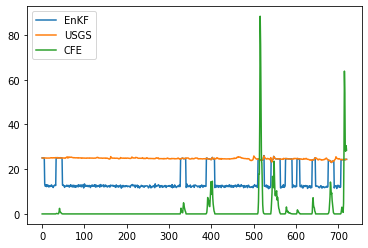

In [28]:
# Make empty matrices for plotting
sim = []
obs = []
cfe = []

############################################
# change this for ENKF
EnKF_results=[]
measurements = []
# Run USG model
USGS_instance.update()
obs = USGS_instance.get_value('Flow')
dim_z=1
dt=1
N=700

# state trans. functions; NEED UPDATE
def hx(x):
    return np.array([x[0]])
def fx(x, dt):
    return F @ x
#####################################################################

for i, precip in enumerate(df_forcing['APCP_surface']): #i is 
    
    framework_time = (1+i)*3600 #seconds since starting simulation
    
    # Run CFE model
    cfe_instance.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
    cfe_instance.update()
    outflow = cfe_instance.get_value('land_surface_water__runoff_depth')
    cfe.append(outflow)
    
    # Peturbation run   
    cfe_instance_peturb.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
    cfe_instance_peturb.update()
    outflow_peturb = cfe_instance_peturb.get_value('land_surface_water__runoff_depth_ens')
    #print(outflow_peturb)
    # Calculate states of ensemble runs
    outflow_peturb_mean = np.mean(outflow_peturb)
    outflow_peturb_std = np.std(outflow_peturb)
    outflow_peturb_var = np.var(outflow_peturb)
    outflow_peturb_covar = np.cov(outflow_peturb)
    
    #obs.append(outflow_peturb_std)
    sim.append(outflow_peturb_mean)#*35.314666212661) # check if the cfs and m3/sec are good.
    
#Assimilation using ENKF
    x=np.array([np.mean(outflow_peturb)])
    P=np.eye(1)*outflow_peturb_covar
    f = Bmi_da_ENKF.EnsembleKalmanFilter(x=x, P=P, dim_z=dim_z, dt=dt,N=N, hx=hx, fx=fx)
    f.initialize(x,P) #
    z = np.array([obs[i]])*10
    F = np.array([[1000]]) # state transition function
    
    f.predict()
    f.update(z)
    EnKF_results.append(f.x)
    measurements.append(z)

plt.plot(results, label='EnKF')
plt.plot(measurements,label='USGS')
plt.plot(sim,label='CFE')
plt.legend(loc=2)

In [ ]:
# check if usefull!!!

In [7]:
# change this
dim_z=1
dt=1
N=1

def hx(x):
    return np.array([x[0]])

def fx(x, dt):
    return F @ x
precip=df_forcing['APCP_surface']
#print(precip)
cfe_instance_peturb.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
#print(precip)
#cfe_instance_peturb.update()
outflow_peturb = cfe_instance_peturb.get_value('land_surface_water__runoff_depth_ens')
#print(outflow_peturb)
# Calculate states of ensemble runs
x = np.array([np.mean(outflow_peturb)])
print('mean',x)
std = np.array([np.std(outflow_peturb)])
#outflow_peturb_var = np.array([np.var(outflow_peturb)])
P =np.eye(1)*np.cov(outflow_peturb)
print('cov',P)
f = Bmi_da_ENKF.EnsembleKalmanFilter(x=x, P=P, dim_z=dim_z, dt=dt, N=N, hx=hx, fx=fx)
print(f)


mean [0.]
cov [[0.]]
EnsembleKalmanFilter object
dim_x = 1
dim_z = 1
dt = 1
x = [0.]
P = [[0.]]
x_prior = [0.]
P_prior = [[0.]]
Q = [[1.]]
R = [[1.]]
K = [[0.]]
S = [[0.]]
sigmas = [[0.]]
hx = <function hx at 0x7faa20e045e0>
fx = <function fx at 0x7faa20e04700>


In [16]:
EnKF_instance = Bmi_da_ENKF.EnsembleKalmanFilter(x=x, P=P, dim_z=dim_z, dt=dt,
                                 N=N, hx=hx, fx=fx)#

In [19]:
EnKF_instance.initialize(x,P) #
z = obs[1]
EnKF_instance.update(z)
#EnKF_instance.pridict(z)

IndexError: invalid index to scalar variable.

In [29]:
# f = Bmi_da_ENKF.EnsembleKalmanFilter(x=outflow_peturb_mean, P=outflow_peturb_covar, dim_z=dim_z, dt=dt,N=N, hx=hx, fx=fx)

TypeError: object of type 'numpy.float64' has no len()

In [ ]:
#usgs_instance = Bmi_da_ENKF.EnsembleKalmanFilter()# 
outflow_peturb_mean = np.mean(outflow_peturb)
outflow_peturb_covar = np.cov(outflow_peturb)
z=USGS_instance.get_value('Flow')
dim_z=1
dt=1 # 1 hr
N=len(outflow_peturb_mean)
outflow_peturb = cfe_instance_peturb.get_value('land_surface_water__runoff_depth_ens')
outflow_peturb_mean = np.mean(outflow_peturb)
outflow_peturb_std = np.std(outflow_peturb)
outflow_peturb_var = np.var(outflow_peturb)
def hx(x):
    return np.array([x[0]])

def fx(x, dt):
    return F @ x

In [10]:
x = np.array([0.]) # mean 
P = np.eye(1) * 100. # covariance
print(len(x))
print('cov',P)
dim_z=1 
dt=1 
N=100 
def hx(x):
    return np.array([x[0]])

def fx(x, dt):
    return F @ x

1
cov [[100.]]


In [32]:
f = Bmi_da_ENKF.EnsembleKalmanFilter(x=x, P=P, dim_z=dim_z, dt=dt,
                                 N=N, hx=hx, fx=fx)
#print(f)

In [33]:
EnKF_instance = Bmi_da_ENKF.EnsembleKalmanFilter(x=x, P=P, dim_z=dim_z, dt=dt,
                                 N=N, hx=hx, fx=fx)#

In [34]:

EnKF_instance.initialize(x,P) #

In [35]:
outputs=EnKF_instance.get_input_var_names()
output_lists = {output:[] for output in outputs}
print(output_lists)

{'x': [], 'P': [], 'dim_z': [], 'dt': [], 'N': [], 'hx': [], 'fx': []}


In [36]:
from numpy.random import randn
z = np.array([1])
print(z.shape)

(1,)


In [37]:
EnKF_instance.update(z)

[1]


In [28]:
F = np.array([1., 1.])
EnKF_instance.predict()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 2)

In [11]:
# -*- coding: utf-8 -*-
# pylint: disable=invalid-name, too-many-arguments, too-many-instance-attributes
# pylint: disable=attribute-defined-outside-init

"""Copyright 2015 Roger R Labbe Jr.
FilterPy library.
http://github.com/rlabbe/filterpy
Documentation at:
https://filterpy.readthedocs.org
Supporting book at:
https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python
This is licensed under an MIT license. See the readme.MD file
for more information.
"""


from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

from copy import deepcopy
import numpy as np
from numpy import array, zeros, eye, dot
from numpy.random import multivariate_normal
from filterpy.common import pretty_str, outer_product_sum


class EnsembleKalmanFilter():
    """
    This implements the ensemble Kalman filter (EnKF). The EnKF uses
    an ensemble of hundreds to thousands of state vectors that are randomly
    sampled around the estimate, and adds perturbations at each update and
    predict step. It is useful for extremely large systems such as found
    in hydrophysics. As such, this class is admittedly a toy as it is far
    too slow with large N.
    There are many versions of this sort of this filter. This formulation is
    due to Crassidis and Junkins [1]. It works with both linear and nonlinear
    systems.
    Parameters
    ----------
    x : np.array(dim_x)
        state mean
    P : np.array((dim_x, dim_x))
        covariance of the state
    dim_z : int
        Number of of measurement inputs. For example, if the sensor
        provides you with position in (x,y), dim_z would be 2.
    dt : float
        time step in seconds
    N : int
        number of sigma points (ensembles). Must be greater than 1.
    K : np.array
        Kalman gain
    hx : function hx(x)
        Measurement function. May be linear or nonlinear - converts state
        x into a measurement. Return must be an np.array of the same
        dimensionality as the measurement vector.
    fx : function fx(x, dt)
        State transition function. May be linear or nonlinear. Projects
        state x into the next time period. Returns the projected state x.
    Attributes
    ----------
    x : numpy.array(dim_x, 1)
        State estimate
    P : numpy.array(dim_x, dim_x)
        State covariance matrix
    x_prior : numpy.array(dim_x, 1)
        Prior (predicted) state estimate. The *_prior and *_post attributes
        are for convienence; they store the  prior and posterior of the
        current epoch. Read Only.
    P_prior : numpy.array(dim_x, dim_x)
        Prior (predicted) state covariance matrix. Read Only.
    x_post : numpy.array(dim_x, 1)
        Posterior (updated) state estimate. Read Only.
    P_post : numpy.array(dim_x, dim_x)
        Posterior (updated) state covariance matrix. Read Only.
    z : numpy.array
        Last measurement used in update(). Read only.
    R : numpy.array(dim_z, dim_z)
        Measurement noise matrix
    Q : numpy.array(dim_x, dim_x)
        Process noise matrix
    fx : callable (x, dt)
        State transition function
    hx : callable (x)
        Measurement function. Convert state `x` into a measurement
    K : numpy.array(dim_x, dim_z)
        Kalman gain of the update step. Read only.
    inv : function, default numpy.linalg.inv
        If you prefer another inverse function, such as the Moore-Penrose
        pseudo inverse, set it to that instead: kf.inv = np.linalg.pinv
    Examples
    --------
    .. code-block:: Python
        def hx(x):
           return np.array([x[0]])
        F = np.array([[1., 1.],
                      [0., 1.]])
        def fx(x, dt):
            return np.dot(F, x)
        x = np.array([0., 1.])
        P = np.eye(2) * 100.
        dt = 0.1
        f = EnsembleKalmanFilter(x=x, P=P, dim_z=1, dt=dt,
                                 N=8, hx=hx, fx=fx)
        std_noise = 3.
        f.R *= std_noise**2
        f.Q = Q_discrete_white_noise(2, dt, .01)
        while True:
            z = read_sensor()
            f.predict()
            f.update(np.asarray([z]))
    See my book Kalman and Bayesian Filters in Python
    https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python
    References
    ----------
    - [1] John L Crassidis and John L. Junkins. "Optimal Estimation of
      Dynamic Systems. CRC Press, second edition. 2012. pp, 257-9.
    """

    def __init__(self, x, P, dim_z, dt, N, hx, fx):
        if dim_z <= 0:
            raise ValueError('dim_z must be greater than zero')

        if N <= 0:
            raise ValueError('N must be greater than zero')

        dim_x = len(x)
        self.dim_x = dim_x
        self.dim_z = dim_z
        self.dt = dt
        self.N = N
        self.hx = hx
        self.fx = fx
        self.K = zeros((dim_x, dim_z))
        self.z = array([[None] * self.dim_z]).T
        self.S = zeros((dim_z, dim_z))   # system uncertainty
        self.SI = zeros((dim_z, dim_z))  # inverse system uncertainty

        self.initialize(x, P)
        self.Q = eye(dim_x)       # process uncertainty
        self.R = eye(dim_z)       # state uncertainty
        self.inv = np.linalg.inv

        # used to create error terms centered at 0 mean for
        # state and measurement
        self._mean = zeros(dim_x)
        self._mean_z = zeros(dim_z)

    def initialize(self, x, P):
        """
        Initializes the filter with the specified mean and
        covariance. Only need to call this if you are using the filter
        to filter more than one set of data; this is called by __init__
        Parameters
        ----------
        x : np.array(dim_z)
            state mean
        P : np.array((dim_x, dim_x))
            covariance of the state
        """

        if x.ndim != 1:
            raise ValueError('x must be a 1D array')

        self.sigmas = multivariate_normal(mean=x, cov=P, size=self.N)
        self.x = x
        self.P = P

        # these will always be a copy of x,P after predict() is called
        self.x_prior = self.x.copy()
        self.P_prior = self.P.copy()

        # these will always be a copy of x,P after update() is called
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()

    def update(self, z, R=None):
        """
        Add a new measurement (z) to the kalman filter. If z is None, nothing
        is changed.
        Parameters
        ----------
        z : np.array
            measurement for this update.
        R : np.array, scalar, or None
            Optionally provide R to override the measurement noise for this
            one call, otherwise self.R will be used.
        """

        if z is None:
            self.z = array([[None]*self.dim_z]).T
            self.x_post = self.x.copy()
            self.P_post = self.P.copy()
            return

        if R is None:
            R = self.R
        if np.isscalar(R):
            R = eye(self.dim_z) * R

        N = self.N
        dim_z = len(z)
        sigmas_h = zeros((N, dim_z))

        # transform sigma points into measurement space
        for i in range(N):
            sigmas_h[i] = self.hx(self.sigmas[i])

        z_mean = np.mean(sigmas_h, axis=0)

        P_zz = (outer_product_sum(sigmas_h - z_mean) / (N-1)) + R
        P_xz = outer_product_sum(
            self.sigmas - self.x, sigmas_h - z_mean) / (N - 1)

        self.S = P_zz
        self.SI = self.inv(self.S)
        self.K = dot(P_xz, self.SI)

        e_r = multivariate_normal(self._mean_z, R, N)
        for i in range(N):
            self.sigmas[i] += dot(self.K, z + e_r[i] - sigmas_h[i])

        self.x = np.mean(self.sigmas, axis=0)
        self.P = self.P - dot(dot(self.K, self.S), self.K.T)

        # save measurement and posterior state
        self.z = deepcopy(z)
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()

    def predict(self):
        """ Predict next position. """

        N = self.N
        for i, s in enumerate(self.sigmas):
            self.sigmas[i] = self.fx(s, self.dt)

        e = multivariate_normal(self._mean, self.Q, N)
        self.sigmas += e

        self.x = np.mean(self.sigmas, axis=0)
        self.P = outer_product_sum(self.sigmas - self.x) / (N - 1)

        # save prior
        self.x_prior = np.copy(self.x)
        self.P_prior = np.copy(self.P)

    def __repr__(self):
        return '\n'.join([
            'EnsembleKalmanFilter object',
            pretty_str('dim_x', self.dim_x),
            pretty_str('dim_z', self.dim_z),
            pretty_str('dt', self.dt),
            pretty_str('x', self.x),
            pretty_str('P', self.P),
            pretty_str('x_prior', self.x_prior),
            pretty_str('P_prior', self.P_prior),
            pretty_str('Q', self.Q),
            pretty_str('R', self.R),
            pretty_str('K', self.K),
            pretty_str('S', self.S),
            pretty_str('sigmas', self.sigmas),
            pretty_str('hx', self.hx),
            pretty_str('fx', self.fx)
            ])

In [ ]:
# after original
# Make empty matrices for plotting
sim = []
obs = []
assimilation = []
cfe = []

# Run USG model
USGS_instance.update()
obs = USGS_instance.get_value('Flow')
#print(obs)
############################################
# change this
dim_z=1
dt=1
N=700

def hx(x):
    return np.array([x[0]])

def fx(x, dt):
    return F @ x
#####################################################################
#print('check'+outflow_peturb_mean)
for i, precip in enumerate(df_forcing['APCP_surface']): #i is 
    
    framework_time = (1+i)*3600 #seconds since starting simulation
    
    # Run CFE model
    cfe_instance.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
    cfe_instance.update()
    outflow = cfe_instance.get_value('land_surface_water__runoff_depth')
    cfe.append(outflow)
    
    # Peturbation run   
    cfe_instance_peturb.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
    cfe_instance_peturb.update()
    outflow_peturb = cfe_instance_peturb.get_value('land_surface_water__runoff_depth_ens')
    #print(outflow_peturb)
    # Calculate states of ensemble runs
    outflow_peturb_mean = np.mean(outflow_peturb)
    outflow_peturb_std = np.std(outflow_peturb)
    outflow_peturb_var = np.var(outflow_peturb)
    outflow_peturb_covar = np.cov(outflow_peturb)
    
    #obs.append(outflow_peturb_std)
    sim.append(outflow_peturb_mean)
    
    #print('The mean is ', outflow_peturb_mean)
    f = Bmi_da_ENKF.EnsembleKalmanFilter(x=x, P=P, dim_z=dim_z, dt=dt,N=N, hx=hx, fx=fx)
    cfe_assimilation.set_value('obs', obs[i]*10) #need these to represent pdf of flows
    cfe_assimilation.set_value('sim', outflow_peturb_mean)
    cfe_assimilation.update()
      # Assimilation
    x=np.array([np.mean(outflow_peturb)])
    P=np.eye(1)*outflow_peturb_covar
    

    
    #
    # Make matrix to put assimilation output
    output = np.zeros(1)
    DA_output = cfe_assimilation.get_value('assimilation', output)
    #print(DA_output)
    assimilation.append(DA_output) #append empty matrix to output for plotting
    
print('The covarince is', outflow_peturb_covar)
# print('The mean is ', outflow_peturb_mean)
# print('The std is ', outflow_peturb_std)